# Synthea COVID-19 Module Analysis

This notebook provides and analysis of data generated by [Synthea](https://synthetichealth.github.io/synthea/)'s COVID-19 module. Analysis is run on the CSV output from Synthea.

Code in this notebook depends on [Pandas](https://pandas.pydata.org/), [NumPy](https://numpy.org/), [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime

In [2]:
%matplotlib inline

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
%load_ext autoreload

In [5]:
%autoreload 1

This jupyter notebook evolved over the creation of the Synthea COVID-19 Module. Initially, all python code was in the notebook. Eventually, this became unwieldy and code was moved into the imported file below.

In [6]:
%aimport analysis

Read in all of the data

In [7]:
conditions = pd.read_csv("../data-set/conditions.zip", compression='zip')
patients = pd.read_csv("../data-set/patients.zip", compression='zip')
observations = pd.read_csv("../data-set/observations.zip", compression='zip')
care_plans = pd.read_csv("../data-set/careplans.zip", compression='zip')
encounters = pd.read_csv("../data-set/encounters.zip", compression='zip')
devices = pd.read_csv("../data-set/devices.zip", compression='zip')
supplies = pd.read_csv("../data-set/supplies.zip", compression='zip')
procedures = pd.read_csv("../data-set/procedures.zip", compression='zip')
medications = pd.read_csv("../data-set/medications.zip", compression='zip')
immunizations = pd.read_csv("../data-set/immunizations.zip", compression='zip')

Grab the IDs of patients that have been diagnosed with COVID-19

In [8]:
covid_patient_ids = conditions[conditions.CODE == 840539006].PATIENT.unique()

This grabs every patient with a negative SARS-CoV-2 test. This will include patients who tested negative up front as well as patients that tested negative after leaving the hospital

In [9]:
negative_covid_patient_ids = observations[(observations.CODE == '94531-1') & (observations.VALUE == 'Not detected (qualifier value)')].PATIENT.unique()

Grabs IDs for all patients that died in the simulation. This will be more than just COVID-19 deaths.

In [10]:
deceased_patients = patients[patients.DEATHDATE.notna()].Id

Grabs IDs for patients that have completed the care plan for isolation at home.

In [11]:
completed_isolation_patients = care_plans[(care_plans.CODE == 736376001) & (care_plans.STOP.notna()) & (care_plans.REASONCODE == 840539006)].PATIENT

Survivors are the union of those who have completed isolation at home or have a negative SARS-CoV-2 test.

In [12]:
survivor_ids = np.union1d(completed_isolation_patients, negative_covid_patient_ids)

Grab IDs for patients with admission due to COVID-19

In [13]:
inpatient_ids = encounters[(encounters.REASONCODE == 840539006) & (encounters.CODE == 1505002)].PATIENT

The number of inpatient survivors

In [14]:
np.intersect1d(inpatient_ids, survivor_ids).shape

(87,)

The number of inpatient non-survivors

In [15]:
np.intersect1d(inpatient_ids, deceased_patients).shape

(26,)

In [16]:
inpatient_ids.shape

(214,)

## Health outcomes experienced by COVID-19 patients

The following table shows different health outcomes that were experienced by COVID-19 patients during the course of the disease.

In [17]:
analysis.outcome_table(inpatient_ids, survivor_ids, deceased_patients, conditions)

,outcome,total,percent of inpatient,survivors,percent survivors,non survivors,percent non survivors
0,Sepsis,73,0.646018,47,0.540230,26,1.000000
1,Respiratory Failure,78,0.690265,52,0.597701,26,1.000000
2,ARDS,28,0.247788,14,0.160920,14,0.538462
3,Heart Failure,13,0.115044,8,0.091954,5,0.192308
4,Septic Shock,23,0.203540,11,0.126437,12,0.461538
5,Coagulopathy,19,0.168142,10,0.114943,9,0.346154
6,Acute Cardiac Injury,3,0.026549,1,0.011494,2,0.076923
7,Acute Kidney Injury,6,0.053097,3,0.034483,3,0.115385


## Lab values for COVID-19 patients

The following code presents lab values taken for COVID-19 patients. Values are separated into survivors and non survivors.

The first block of code selects lab values of interest from all observations in the simulation.

In [18]:
lab_obs = observations[(observations.CODE == '48065-7') | (observations.CODE == '26881-3') | 
                          (observations.CODE == '2276-4') | (observations.CODE == '89579-7') |
                          (observations.CODE == '2532-0') | (observations.CODE == '731-0') |
                          (observations.CODE == '14804-9')
                      ]

Select COVID-19 conditions out of all conditions in the simulation

In [19]:
covid_conditions = conditions[conditions.CODE == 840539006]

Merge the COVID-19 conditions with the patients

In [20]:
covid_patients = covid_conditions.merge(patients, how='left', left_on='PATIENT', right_on='Id')

Add an attribute to the DataFrame indicating whether this is a survivor or not.

In [21]:
covid_patients['survivor'] = covid_patients.PATIENT.isin(survivor_ids)

Reduce the columns on the DataFrame to ones needed

In [22]:
covid_patients = covid_patients[['START', 'PATIENT', 'survivor', 'CODE']]

Calculate attributes needed to support the plot. Also coerce all lab values into a numeric data type.

In [23]:
covid_patients_obs = covid_patients.merge(lab_obs, on='PATIENT')
covid_patients_obs['START'] = pd.to_datetime(covid_patients_obs.START, utc=True)
covid_patients_obs['DATE'] = pd.to_datetime(covid_patients_obs.DATE)
covid_patients_obs['lab_days'] = covid_patients_obs.DATE - covid_patients_obs.START
covid_patients_obs['days'] = np.around(covid_patients_obs.lab_days / np.timedelta64(1, 'D'))
covid_patients_obs['VALUE'] = pd.to_numeric(covid_patients_obs['VALUE'], errors='coerce')

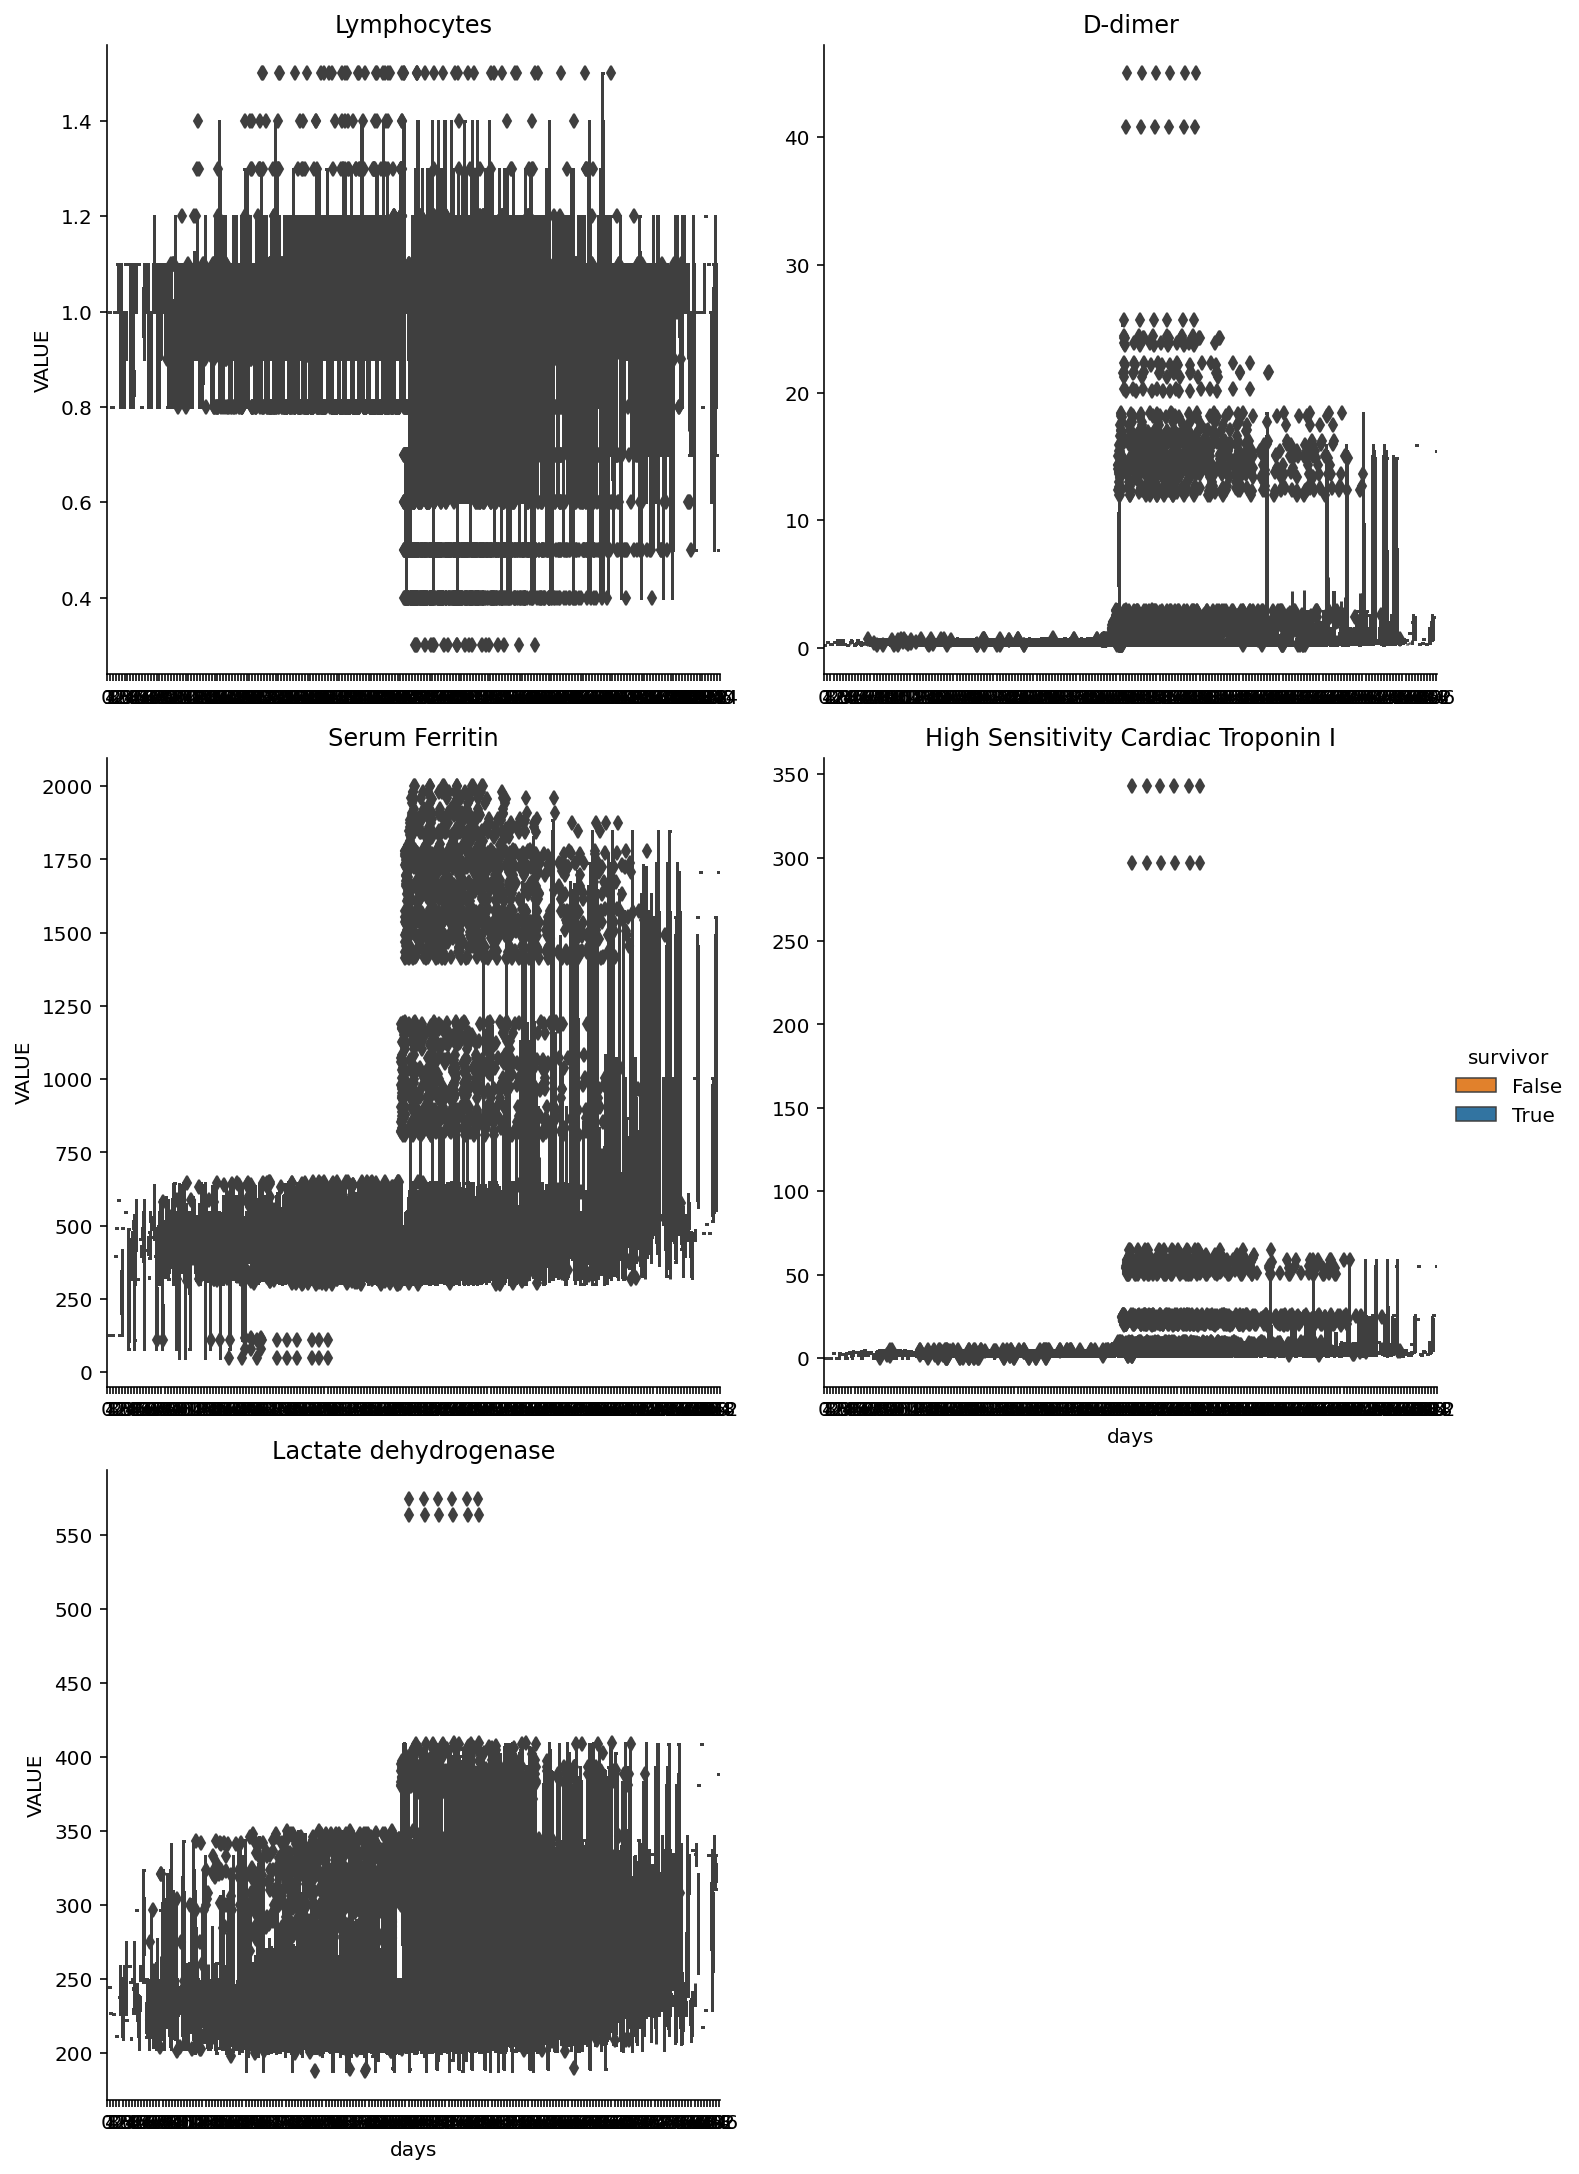

In [24]:
loinc_to_display = {'CODE_y = 48065-7': 'D-dimer', 'CODE_y = 2276-4': 'Serum Ferritin',
                    'CODE_y = 89579-7': 'High Sensitivity Cardiac Troponin I',
                    'CODE_y = 26881-3': 'IL-6', 'CODE_y = 731-0': 'Lymphocytes',
                    'CODE_y = 14804-9': 'Lactate dehydrogenase'}
catplt = sns.catplot(x="days", y="VALUE", hue="survivor", kind="box", col='CODE_y', 
            col_wrap=2, sharey=False, sharex=False, data=covid_patients_obs, palette=["C1", "C0"])

for axis in catplt.fig.axes:
    axis.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axis.xaxis.set_major_locator(ticker.MultipleLocator(base=4))
    axis.set_title(loinc_to_display[axis.title.get_text()])
        
plt.show()

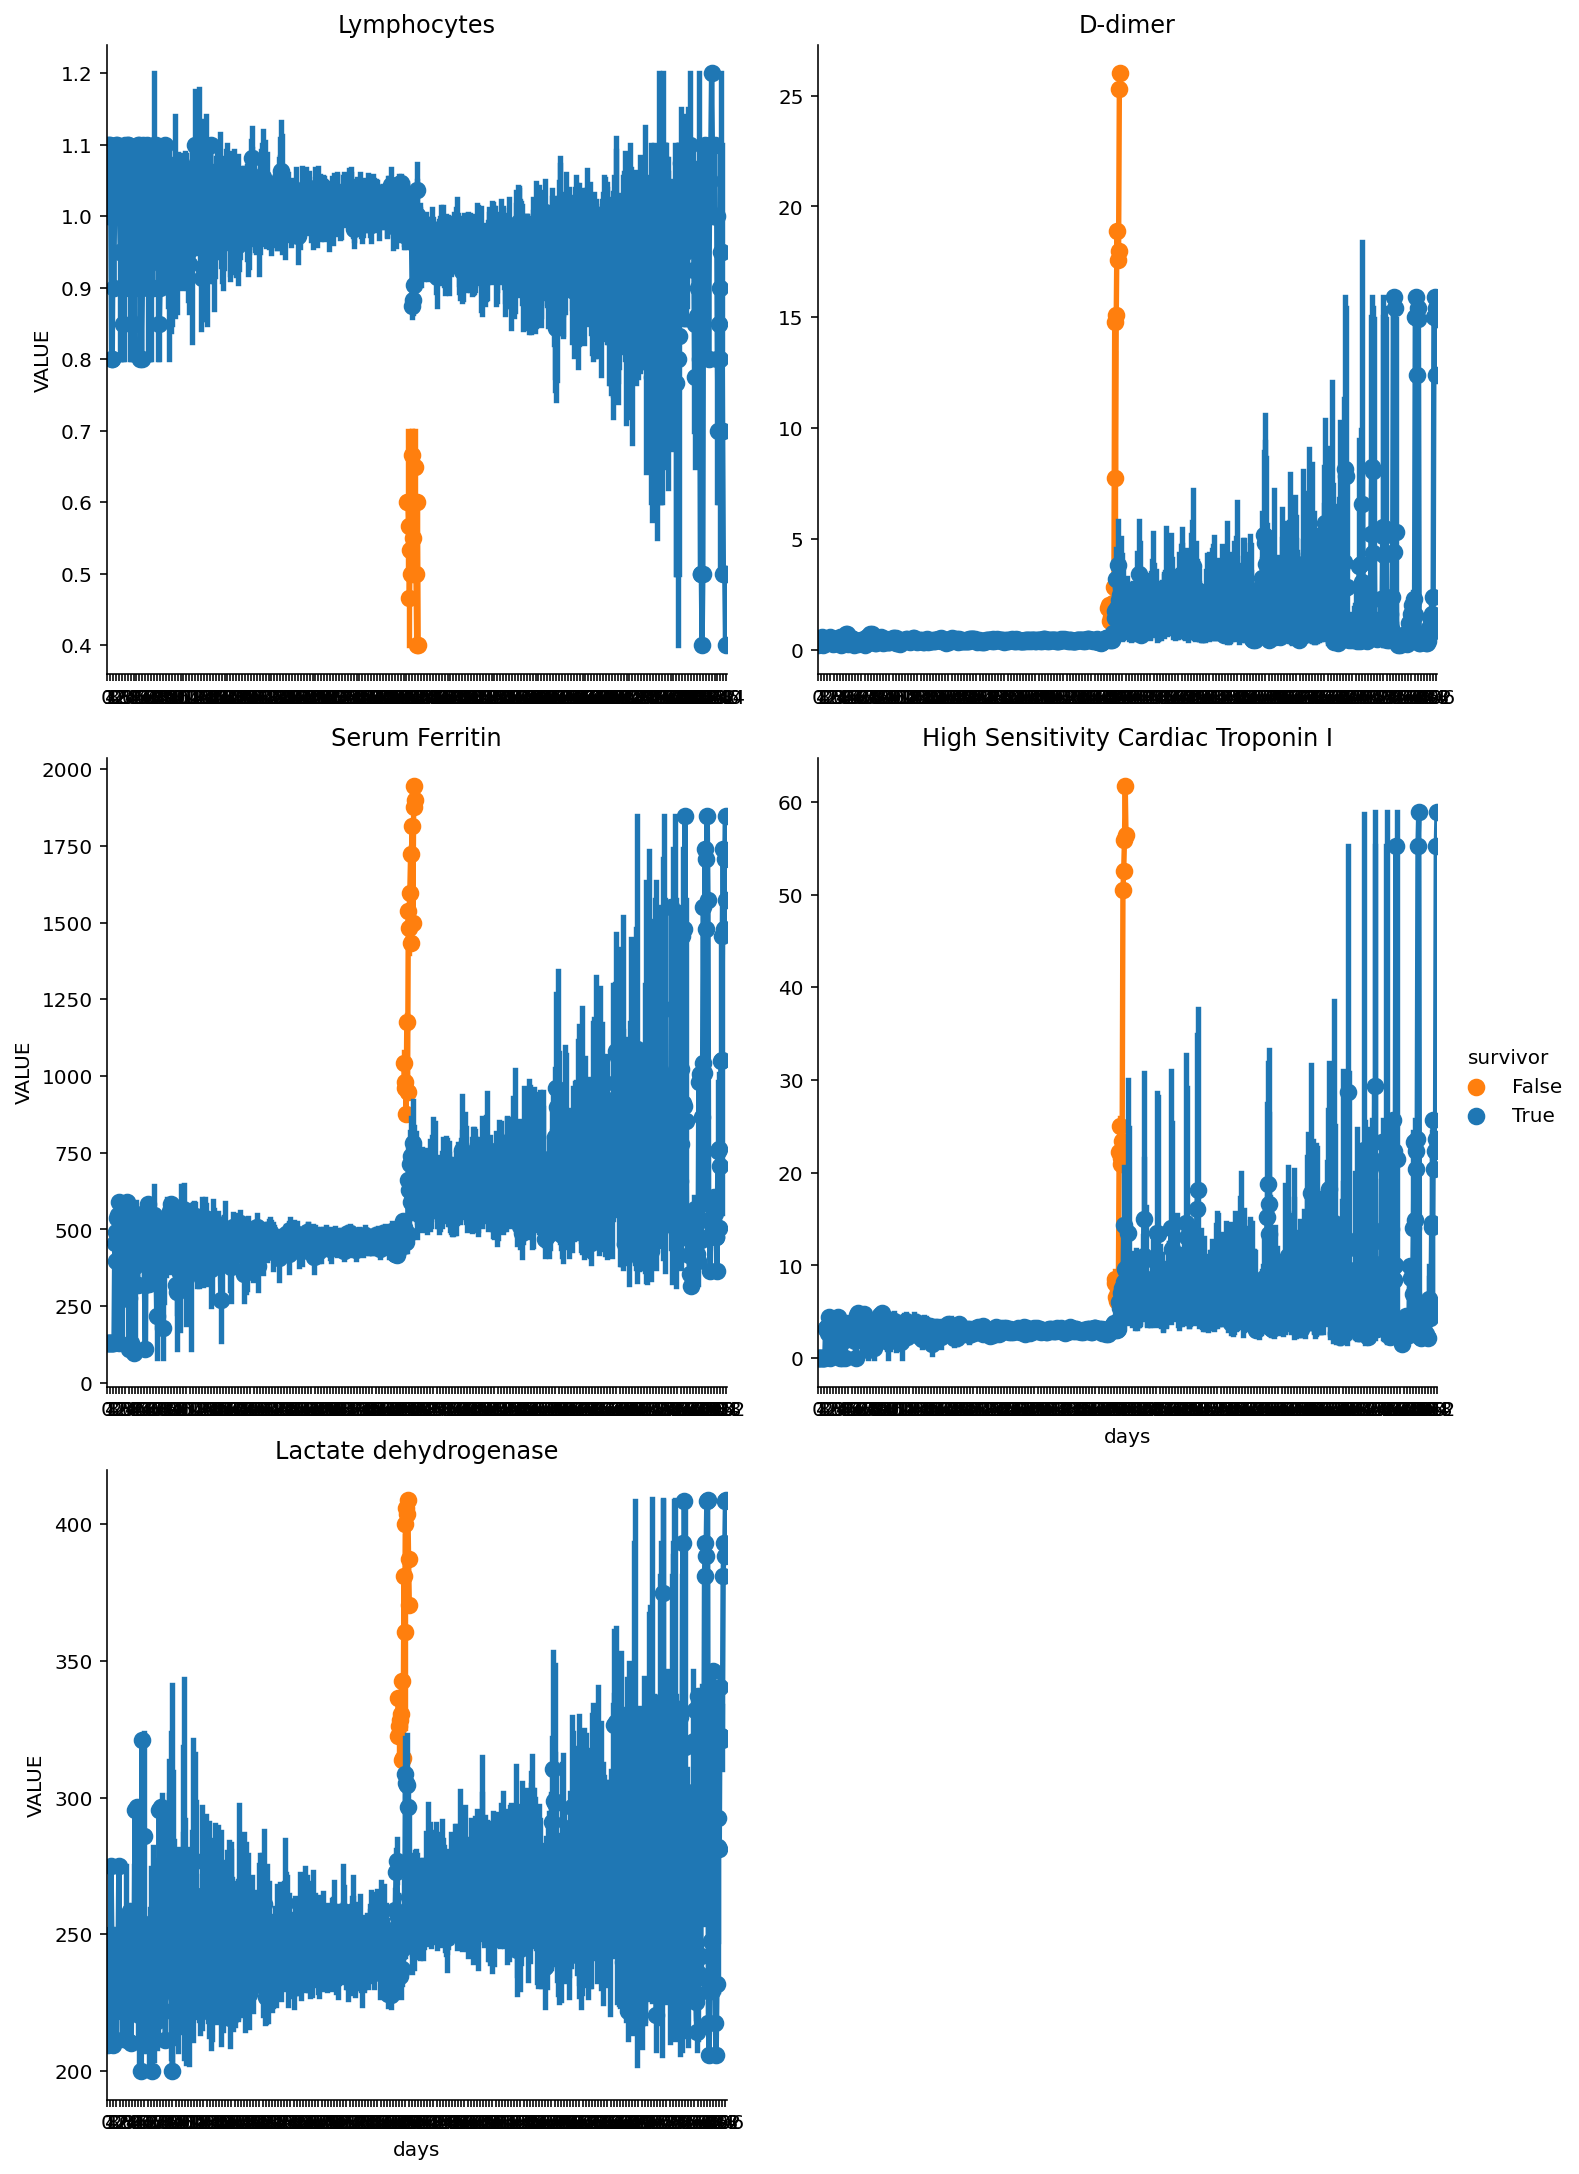

In [25]:
loinc_to_display = {'CODE_y = 48065-7': 'D-dimer', 'CODE_y = 2276-4': 'Serum Ferritin',
                    'CODE_y = 89579-7': 'High Sensitivity Cardiac Troponin I',
                    'CODE_y = 26881-3': 'IL-6', 'CODE_y = 731-0': 'Lymphocytes',
                    'CODE_y = 14804-9': 'Lactate dehydrogenase'}
catplt = sns.catplot(x="days", y="VALUE", hue="survivor", kind="point", col='CODE_y', 
            col_wrap=2, sharey=False, sharex=False, data=covid_patients_obs, palette=["C1", "C0"])

for axis in catplt.fig.axes:
    axis.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    axis.xaxis.set_major_locator(ticker.MultipleLocator(base=4))
    axis.set_title(loinc_to_display[axis.title.get_text()])

plt.show()

Set up a new DataFrame with boolean columns representing various outcomes, like admit, recovery or death

In [26]:
cp = covid_conditions.merge(patients, how='left', left_on='PATIENT', right_on='Id')
isolation_ids = care_plans[(care_plans.CODE == 736376001) & (care_plans.REASONCODE == 840539006)].PATIENT
cp['isolation'] = cp.Id.isin(isolation_ids)
cp['admit'] = cp.Id.isin(inpatient_ids)
cp['recovered'] = cp.Id.isin(survivor_ids)
cp['death'] = cp.DEATHDATE.notna()
icu_ids = encounters[encounters.CODE == 305351004].PATIENT
cp['icu_admit'] = cp.Id.isin(icu_ids)
vent_ids = procedures[procedures.CODE == 26763009].PATIENT
cp['ventilated'] = cp.Id.isin(vent_ids)

## Outcomes for all COVID-19 Patients

This code builds a new DataFrame for the purposes of display. The DataFrame contains the percentages of patients that experience a particular outcome. Percentages are then provided for only hospitalized patients, ICU admitted patients and ventilated patients.

In [27]:
hospitalized = (cp.admit == True)
icu = (cp.icu_admit == True)
vent = (cp.ventilated == True)
covid_count = cp.Id.size
row_filters = {'Home Isolation': (cp.isolation == True), 'Hospital Admission': hospitalized, 'ICU Admission': icu,
 'Ventilated': vent, 'Recovered': (cp.recovered == True), 'Death': (cp.death == True)}

table_rows = []
for category, row_filter in row_filters.items():
    row = {'Outcome': category}
    row['All Patients'] = cp[row_filter].Id.size / covid_count
    row['Hospitalized'] = cp[row_filter & hospitalized].Id.size / hospitalized.value_counts()[True]
    row['ICU Admitted'] = cp[row_filter & icu].Id.size / icu.value_counts()[True]
    row['Required Ventilation'] = cp[row_filter & vent].Id.size / vent.value_counts()[True]
    table_rows.append(row)
    
pd.DataFrame.from_records(table_rows)

,Outcome,All Patients,Hospitalized,ICU Admitted,Required Ventilation
0,Home Isolation,0.997527,0.996760,0.997290,0.995935
1,Hospital Admission,0.763397,1.000000,1.000000,1.000000
2,ICU Admission,0.304204,0.398488,1.000000,1.000000
3,Ventilated,0.202803,0.265659,0.666667,1.000000
4,Recovered,0.996702,0.996760,0.997290,0.995935
5,Death,0.185491,0.236501,0.441734,0.536585


## Outcomes for ICU Admitted Patients

Essentially a sub table from above, looking only at ICU patients.

In [28]:
icu_only = cp[cp.icu_admit == True]

vent = (icu_only.ventilated == True)
covid_count = icu_only.Id.size
row_filters = {'Ventilated': vent, 'Recovered': (icu_only.recovered == True), 'Death': (icu_only.death == True)}

table_rows = []
for category, row_filter in row_filters.items():
    row = {'Outcome': category}
    row['ICU Admitted'] = icu_only[row_filter].Id.size / covid_count
    row['Required Ventilation'] = icu_only[row_filter & vent].Id.size / vent.value_counts()[True]
    table_rows.append(row)
    
pd.DataFrame.from_records(table_rows)

,Outcome,ICU Admitted,Required Ventilation
0,Ventilated,0.666667,1.000000
1,Recovered,0.997290,0.995935
2,Death,0.441734,0.536585


Start to build a DataFrame that we can use to look at other conditions in relation to COVID-19

In [29]:
covid_info = cp[['PATIENT', 'recovered', 'death', 'START', 'DEATHDATE', 'BIRTHDATE', 'GENDER', 'admit', 'icu_admit']]

In [30]:
covid_info = covid_info.rename(columns={'START': 'covid_start'})

Grab all of the conditions starting after January 20, 2020. This is a hack to get only conditions that are related to COVID-19. We will end up merging these with the COVID patients.

In [31]:
covid_related_conditions = conditions[pd.to_datetime(conditions.START) > pd.to_datetime('2020-01-20')]

This DataFrame will contain all conditions for COVID-19 patients, where `START` can be compared to `covid_start` to see how long after the COVID-19 diagnosis something happened.

In [32]:
covid_patient_conditions = covid_info.merge(covid_related_conditions, on='PATIENT')

## Symptoms for all COVID-19 Patients

Generates a DataFrame with percentages of co-occurring conditions

In [33]:
analysis.symptom_table(covid_patient_conditions)

,Symptoms,All Patients Percentage,All Patients Count,Survivor Percentage,Survivor Count,Non Survivor Percentage,Non Survivor Count
0,Conjunctival Congestion,0.984252,125,1.008130,124,1.592593,43
1,Nasal Congestion,5.173228,657,5.341463,657,6.185185,167
2,Headache,14.858268,1887,15.341463,1887,13.814815,373
3,Cough,78.196850,9931,80.723577,9929,65.185185,1760
4,Sore Throat,15.283465,1941,15.780488,1941,8.925926,241
5,Sputum Production,38.007874,4827,39.227642,4825,24.555556,663
6,Fatigue,43.173228,5483,44.560976,5481,33.148148,895
7,Hemoptysis,1.220472,155,1.260163,155,0.703704,19
8,Shortness of Breath,24.944882,3168,25.739837,3166,23.407407,632
9,Nausea,6.559055,833,6.772358,833,6.333333,171


## Symptoms for ICU admitted COVID-19 Patients

DataFrame limited to individuals admitted to the ICU

In [34]:
analysis.symptom_table(covid_patient_conditions, True)

,Symptoms,All Patients Percentage,All Patients Count,Survivor Percentage,Survivor Count,Non Survivor Percentage,Non Survivor Count
0,Conjunctival Congestion,2.37500,76,2.451613,76,1.882353,32
1,Nasal Congestion,7.96875,255,8.225806,255,7.823529,133
2,Headache,22.50000,720,23.225806,720,17.764706,302
3,Cough,100.31250,3210,103.548387,3210,72.529412,1233
4,Sore Throat,19.96875,639,20.612903,639,12.176471,207
5,Sputum Production,52.81250,1690,54.483871,1689,31.058824,528
6,Fatigue,60.84375,1947,62.806452,1947,43.294118,736
7,Hemoptysis,2.75000,88,2.838710,88,1.117647,19
8,Shortness of Breath,35.31250,1130,36.419355,1129,28.352941,482
9,Nausea,11.46875,367,11.838710,367,9.705882,165


Create a DataFrame with columns that show a condition's start and end in days relative to COVID-19 diagnosis. Also create a column that calculates the number of days between COVID-19 diagnosis and a person's death.

In [35]:
covid_patient_conditions['start_days'] = (pd.to_datetime(covid_patient_conditions.START) - pd.to_datetime(covid_patient_conditions.covid_start)) / np.timedelta64(1, 'D')
covid_patient_conditions['end_days'] = (pd.to_datetime(covid_patient_conditions.STOP) - pd.to_datetime(covid_patient_conditions.covid_start)) / np.timedelta64(1, 'D')
covid_patient_conditions['death_days'] = (pd.to_datetime(covid_patient_conditions.DEATHDATE) - pd.to_datetime(covid_patient_conditions.covid_start)) / np.timedelta64(1, 'D')

## Timelines for hospitalized patients

These plots show the progression of COVID-19 related complications in hospitalized patients. The bars represent the average start and end time for the particular item. Arrows at the bottom show the time or start time of a particular item.

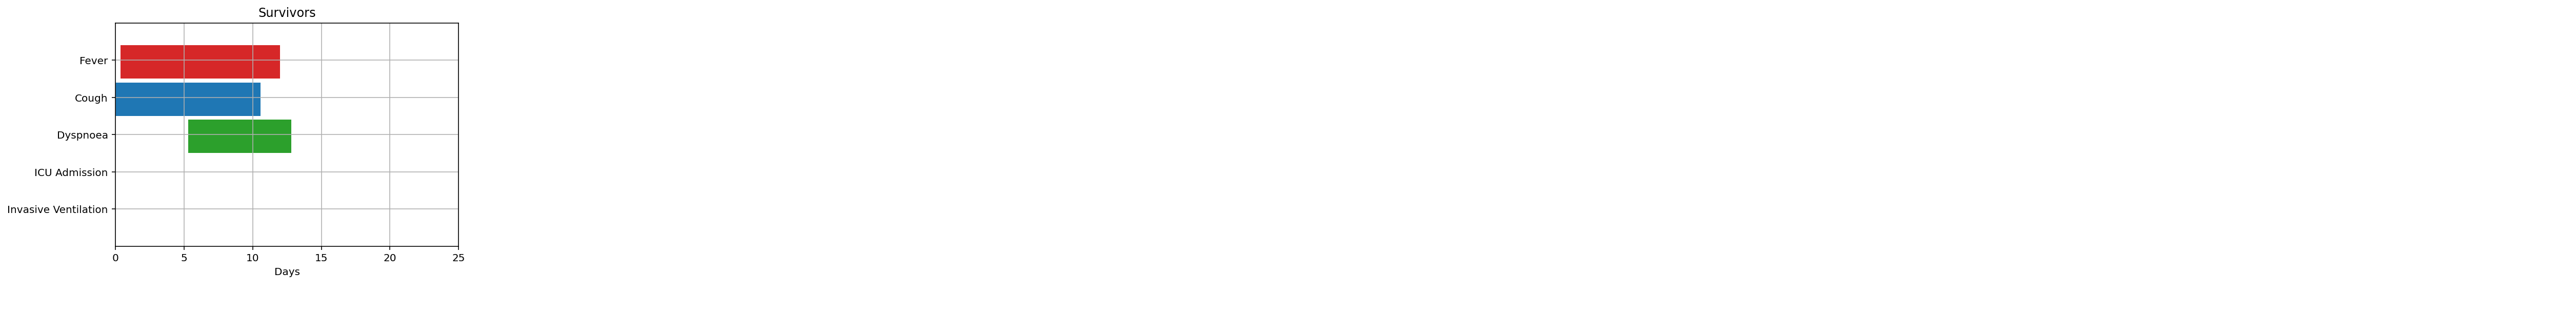

In [36]:
averages = analysis.select_condition_averages(covid_patient_conditions, ((covid_patient_conditions.recovered == True) &
                                                               (covid_patient_conditions.admit == True)))
analysis.survivor_timeline_plot(encounters, devices, averages, covid_patient_conditions, covid_info)

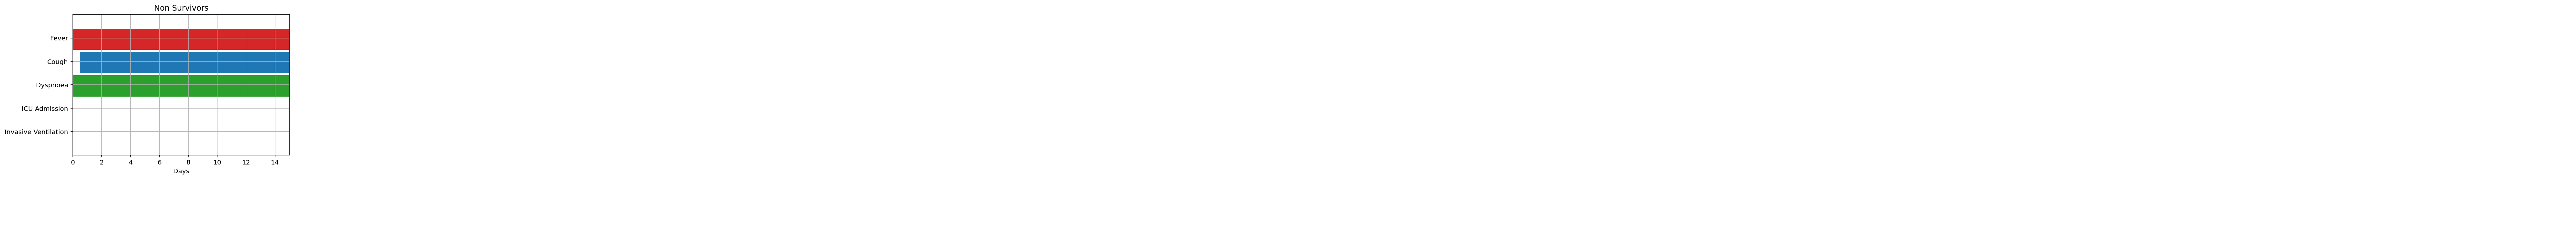

In [37]:
averages = analysis.select_condition_averages(covid_patient_conditions, ((covid_patient_conditions.death == True) &
                                                               (covid_patient_conditions.admit == True)))
analysis.non_survivor_timeline_plot(encounters, devices, averages, covid_patient_conditions, covid_info)

## Timelines for ICU only patients

These plots refine the timelines to only patients with ICU admissions

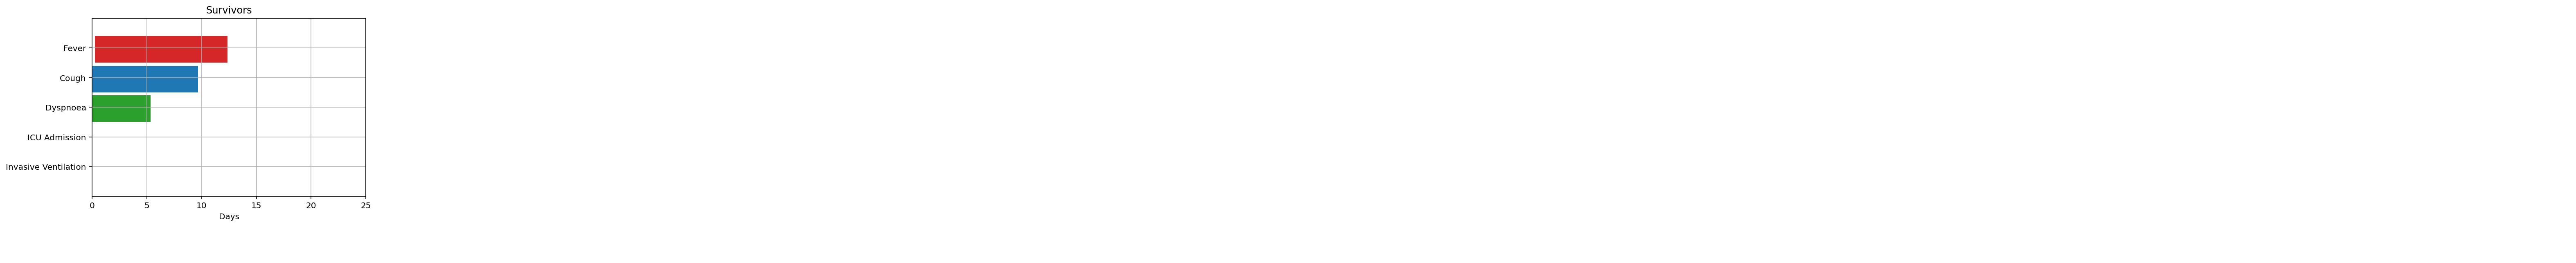

In [38]:
averages = analysis.select_condition_averages(covid_patient_conditions, ((covid_patient_conditions.recovered == True) &
                                                               (covid_patient_conditions.icu_admit == True)))
analysis.survivor_timeline_plot(encounters, devices, averages, covid_patient_conditions, covid_info, True)

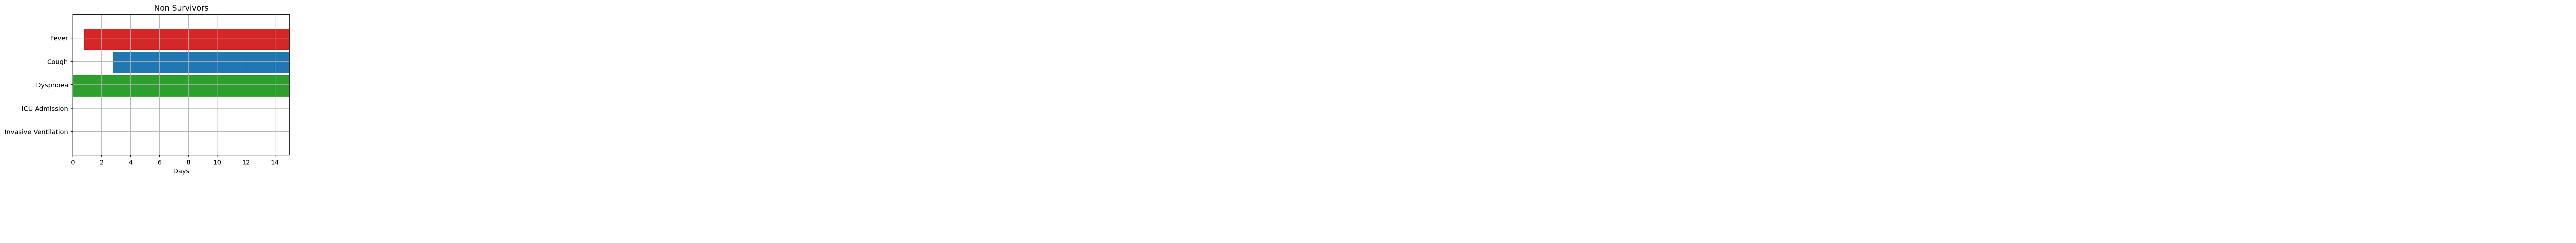

In [39]:
averages = analysis.select_condition_averages(covid_patient_conditions, ((covid_patient_conditions.death == True) &
                                                               (covid_patient_conditions.icu_admit == True)))
analysis.non_survivor_timeline_plot(encounters, devices, averages, covid_patient_conditions, covid_info)

Add an age column to the DataFrame for rows where the patient has died

In [40]:
covid_info.loc[covid_info.death == True, 'age'] = (pd.to_datetime(covid_info.DEATHDATE) - pd.to_datetime(covid_info.BIRTHDATE)) / np.timedelta64(1, 'Y')

Populate ages for survivors based on the current date

In [41]:
covid_info.loc[covid_info.recovered == True, 'age'] = (datetime.datetime.now() - pd.to_datetime(covid_info.BIRTHDATE)) / np.timedelta64(1, 'Y')

Create an age_range column that places individuals into 10 year age ranges, such as 0 - 10, 10 - 20, etc.

In [42]:
bins = list(range(0, 120, 10))
covid_info['age_range'] = pd.cut(covid_info.age, bins=bins)

## Mortality by Age and Sex

A plot of deaths grouped by age range and gender.

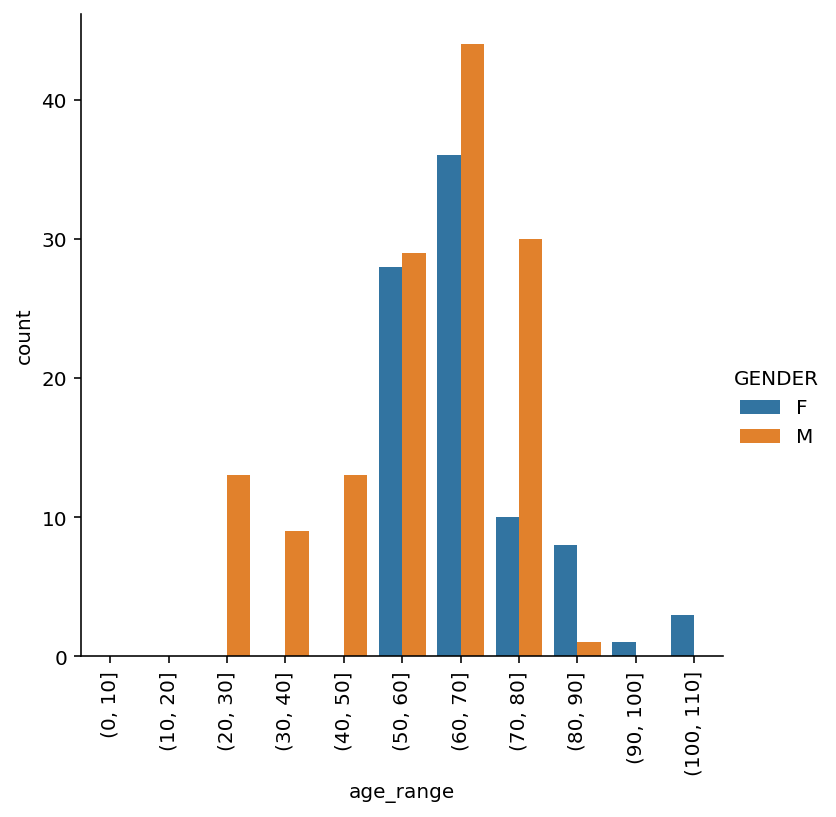

In [43]:
chart = sns.catplot(x="age_range", kind="count", hue="GENDER", data=covid_info[covid_info.death==True]);
for axes in chart.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

A table view of the same information from above

In [44]:
covid_info[covid_info.death==True].groupby(['age_range', 'GENDER']).count()[['PATIENT']]

PATIENT
age_range  GENDER         
(0, 10]    F           NaN
           M           NaN
(10, 20]   F           NaN
           M           NaN
(20, 30]   F           NaN
           M          13.0
(30, 40]   F           NaN
           M           9.0
(40, 50]   F           NaN
           M          13.0
(50, 60]   F          28.0
           M          29.0
(60, 70]   F          36.0
           M          44.0
(70, 80]   F          10.0
           M          30.0
(80, 90]   F           8.0
           M           1.0
(90, 100]  F           1.0
           M           NaN
(100, 110] F           3.0
           M           NaN

Another table view of the mortality data, this time just grouped by age range

In [45]:
covid_info[covid_info.death==True].groupby(['age_range']).count()[['PATIENT']]

,PATIENT
age_range,
"(0, 10]",0
"(10, 20]",0
"(20, 30]",13
"(30, 40]",9
"(40, 50]",13
"(50, 60]",57
"(60, 70]",80
"(70, 80]",40
"(80, 90]",9


Build a DataFrame that shows the total count of a supply used on a given day

In [46]:
grouped_supplies = supplies.groupby(['DESCRIPTION', 'DATE']).sum()

## Supply Usage

Small multiples plot of supply usage over time.

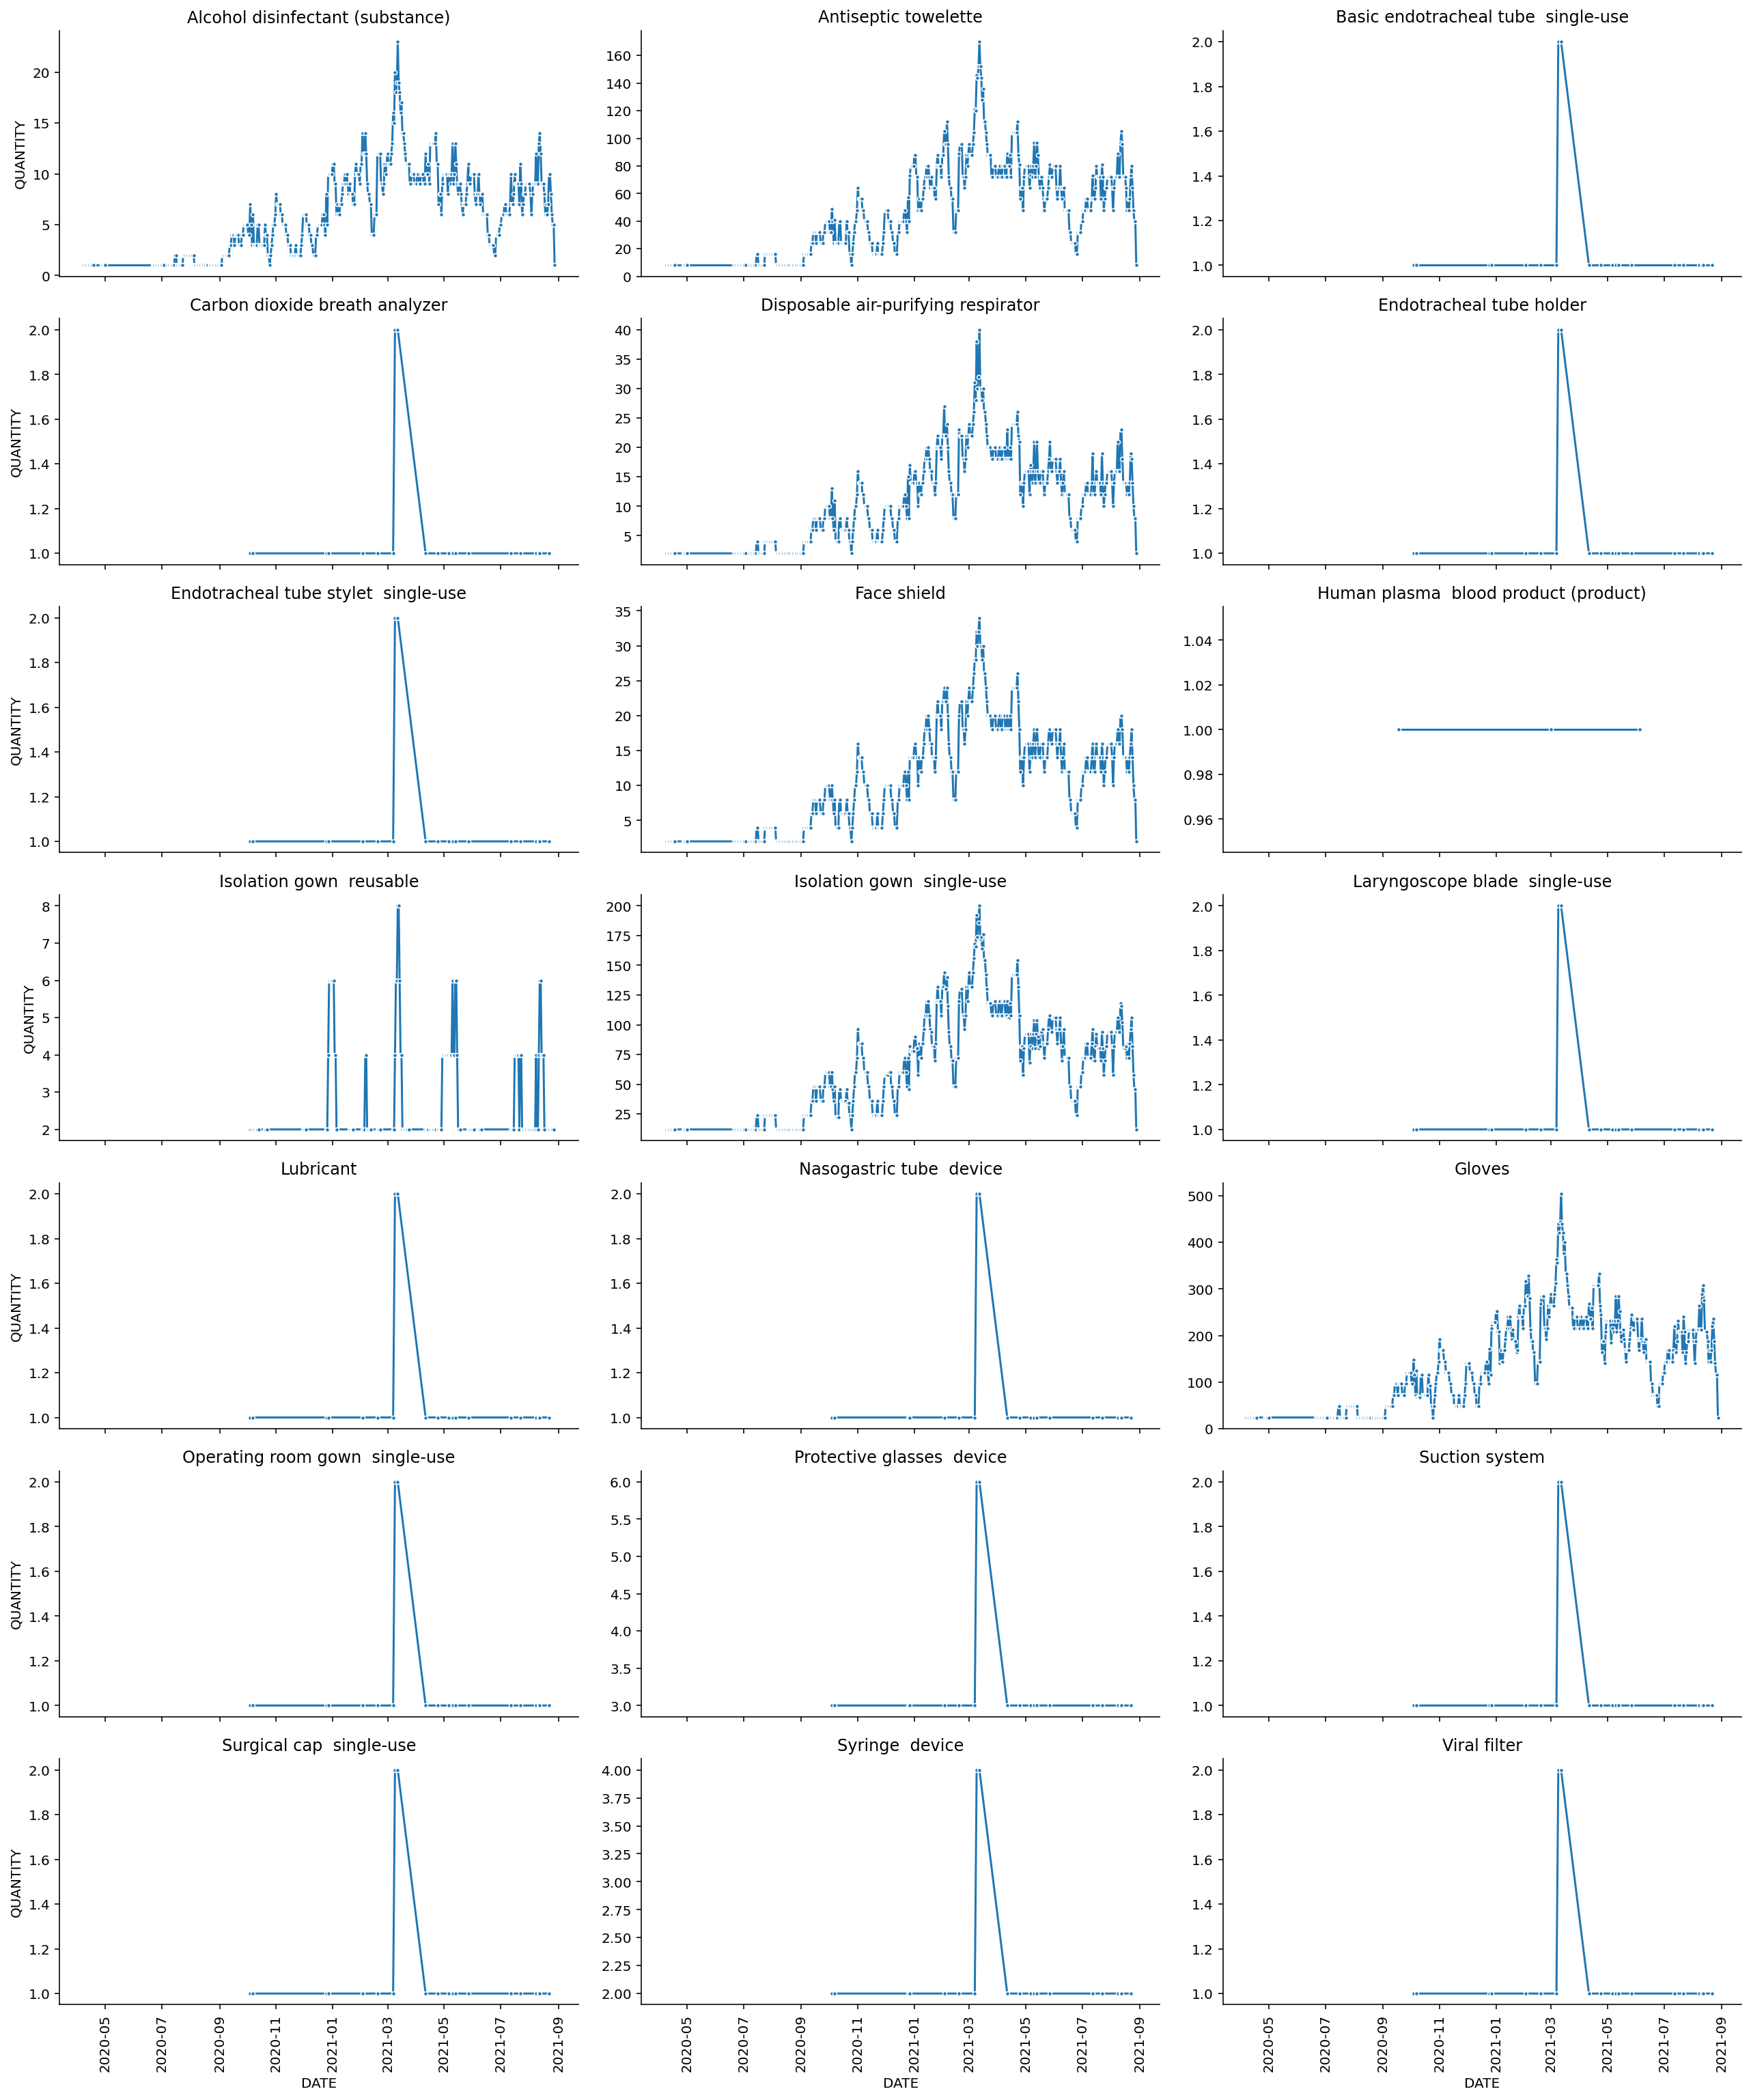

In [47]:
gs = grouped_supplies.reset_index()
gs['DATE'] = pd.to_datetime(gs.DATE)
g = sns.FacetGrid(gs, col="DESCRIPTION", col_wrap=3, sharey=False, height=3, aspect=2)
g = g.map(sns.lineplot, "DATE", "QUANTITY", marker=".")
for axes in g.axes.flat:
    title = axes.get_title()
    if 'glove' in title:
        axes.set_title('Gloves')
    else:    
        axes.set_title(title.replace("DESCRIPTION = ", "").replace(" (physical object)", ""))
    for tick in axes.get_xticklabels():
        tick.set_rotation(90)

A table showing total supplies used over the entire simulation

In [48]:
supplies.groupby(['DESCRIPTION']).sum()[['QUANTITY']]

,QUANTITY
DESCRIPTION,
Alcohol disinfectant (substance),2778
Antiseptic towelette (physical object),22063
Basic endotracheal tube single-use (physical object),23
Carbon dioxide breath analyzer (physical object),23
Disposable air-purifying respirator (physical object),5133
Endotracheal tube holder (physical object),23
Endotracheal tube stylet single-use (physical object),23
Face shield (physical object),5064
Human plasma blood product (product),3


Build a DataFrame that has cumulative case counts over time

In [49]:
case_counts = conditions[conditions.CODE == 840539006].groupby('START').count()[['PATIENT']]
case_counts['total'] = case_counts['PATIENT'].cumsum()
case_counts = case_counts.rename(columns={'PATIENT': 'daily'})
case_counts = case_counts.reset_index()
case_counts['START'] = pd.to_datetime(case_counts.START)

## Cumulative Case Count

Show total cases over time

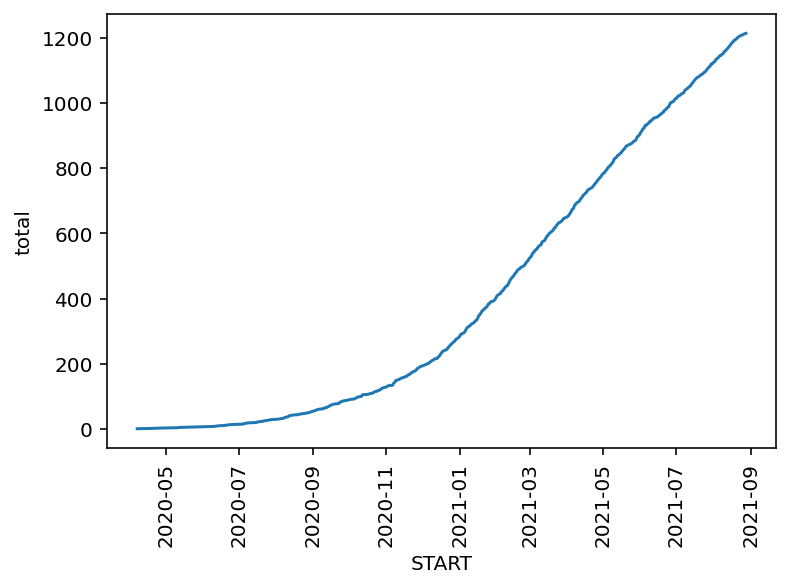

In [50]:
axes = sns.lineplot(x='START', y='total', data=case_counts)
plt.xticks(rotation=90)
plt.show()

## Medication Dispenses

This table shows medications dispensed to patients with COVID-19 since January 20, 2020.

In [51]:
covid_meds = medications[pd.to_datetime(medications.START) > pd.to_datetime('2020-01-20', utc=True)]
covid_meds = covid_info.merge(covid_meds, on='PATIENT')

In [52]:
covid_meds.groupby(['DESCRIPTION']).sum()[['DISPENSES']].sort_values('DISPENSES', ascending=False).head(10)

,DISPENSES
DESCRIPTION,
NDA020503 200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered Dose Inhaler,130186
lisinopril 10 MG Oral Tablet,79761
amLODIPine 2.5 MG Oral Tablet,52291
Albuterol 5 MG/ML Inhalation Solution,16045
Acetaminophen 500 MG Oral Tablet,5671
0.4 ML Enoxaparin sodium 100 MG/ML Prefilled Syringe,5663
Simvastatin 10 MG Oral Tablet,2782
Hydrochlorothiazide 25 MG Oral Tablet,1988
1 ML Enoxaparin sodium 150 MG/ML Prefilled Syringe,1611


## Hospital Day Stats

For patients with COVID-19, calculate the average hospital length of stay as well as total hospital days for all COVID-19 patients. Provide the same information for ICU patients

In [53]:
covid_hosp = analysis.create_covid_hosp(covid_info, encounters, {'admit': True}).reset_index()
covid_icu = analysis.create_covid_icu(covid_info, encounters)
pd.DataFrame.from_records([
    {
        'type': 'inpatient',
        'patients': covid_hosp.PATIENT.nunique(),
        'average stay': ((covid_hosp.STOP - covid_hosp.START) / np.timedelta64(1, 'D')).mean(),
        'total days': ((covid_hosp.STOP - covid_hosp.START) / np.timedelta64(1, 'D')).sum(),
    },
    {
        'type': 'ICU',
        'patients': covid_icu.PATIENT.nunique(),
        'average stay': ((pd.to_datetime(covid_icu.STOP) - pd.to_datetime(covid_icu.START, utc=True)) / np.timedelta64(1, 'D')).mean(),
        'total days': ((pd.to_datetime(covid_icu.STOP) - pd.to_datetime(covid_icu.START, utc=True)) / np.timedelta64(1, 'D')).sum(),
    }
])

,type,patients,average stay,total days
0,inpatient,90,88.647240,7978.251620
1,ICU,32,4.920792,2184.831794


In [54]:
device_codes = [448907002, 449071006, 36965003]
grouped_dev = devices[devices.CODE.isin(device_codes)].copy()
grouped_dev['START'] = pd.to_datetime(grouped_dev.START).dt.date
grouped_dev = grouped_dev.groupby(['DESCRIPTION', 'START']).count()
grouped_dev = grouped_dev.reset_index()

## Device Usage

Show the number of devices used to treat COVID-19 over time.

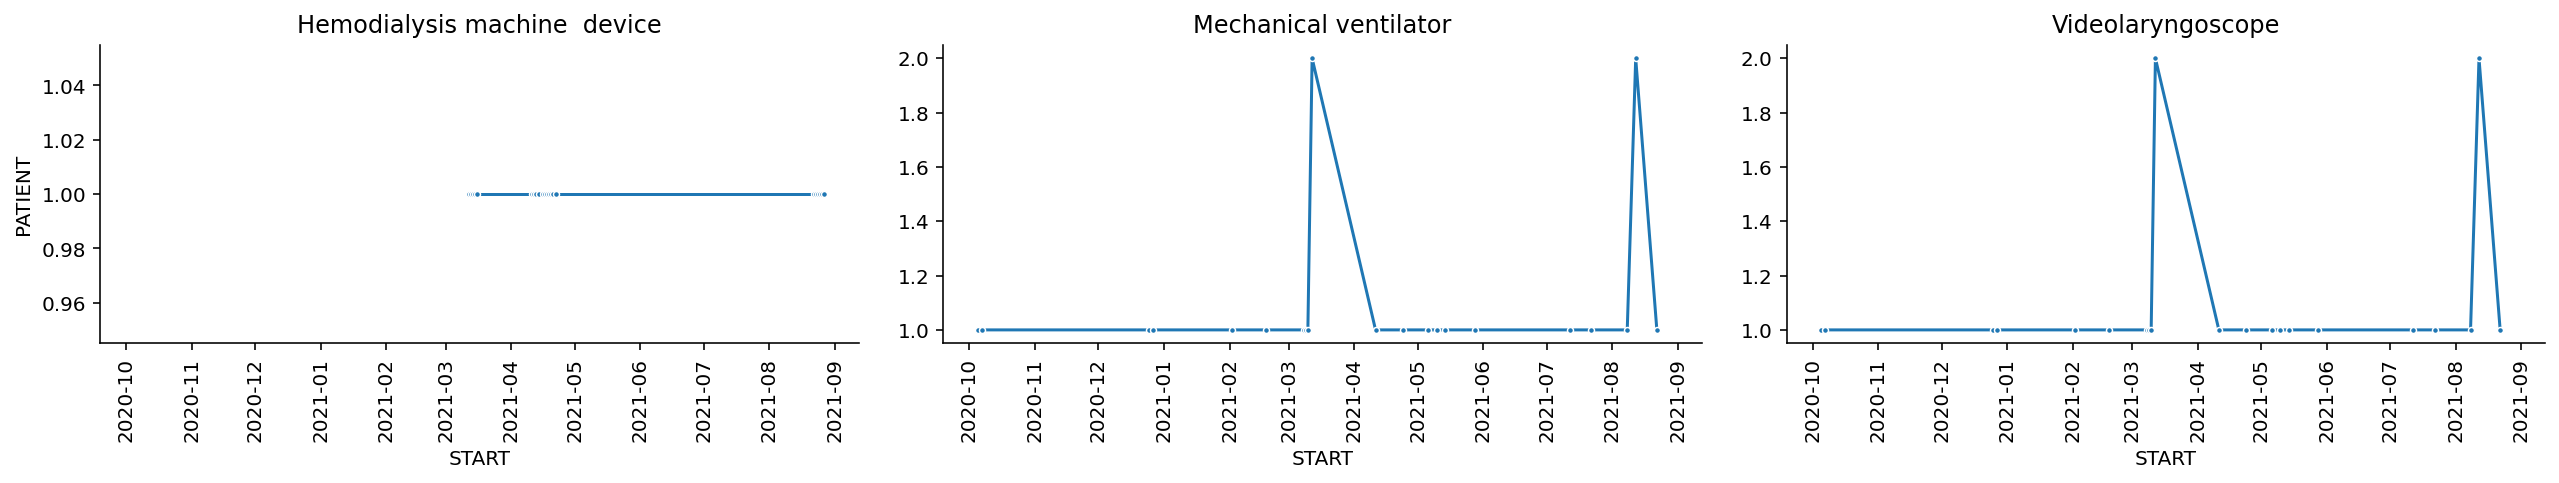

In [55]:
g = sns.FacetGrid(grouped_dev, col="DESCRIPTION", col_wrap=3, sharey=False, height=3, aspect=2)
g = g.map(sns.lineplot, "START", "PATIENT", marker=".")
for axes in g.axes.flat:
    title = axes.get_title()
    axes.set_title(title.replace("DESCRIPTION = ", "").replace(" (physical object)", ""))
    for tick in axes.get_xticklabels():
        tick.set_rotation(90)

## A Closer Look at Case Counts

Checking the daily case counts

In [56]:
case_counts

,START,daily,total
0,2020-04-07,1,1
1,2020-04-20,1,2
2,2020-04-27,1,3
3,2020-05-10,1,4
4,2020-05-13,1,5
...,...,...,...
375,2021-08-24,2,1207
376,2021-08-25,1,1208
377,2021-08-26,2,1210
378,2021-08-27,2,1212


In [57]:
case_counts.daily.describe()

count    380.000000
mean       3.192105
std        1.939029
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       10.000000
Name: daily, dtype: float64

A line plot of cases per day

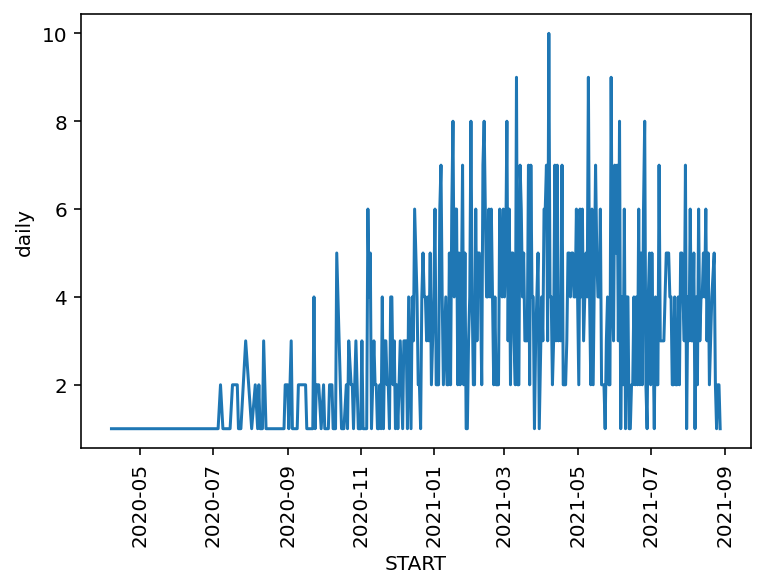

In [58]:
axes = sns.lineplot(x='START', y='daily', data=case_counts)
plt.xticks(rotation=90)
plt.show()

## COVID-19 Immunizations

This section examines COVID-19 immunizations and breakthrough infections.

In [59]:
immunizations['DATE'] = pd.to_datetime(immunizations.DATE).dt.date
covid_immunizations = immunizations[immunizations.CODE.isin([207,208,212])]
shot_counts = covid_immunizations.groupby('DATE').count()[['PATIENT']]
shot_counts['total'] = shot_counts['PATIENT'].cumsum()
shot_counts = shot_counts.rename(columns={'PATIENT': 'daily'})
shot_counts = shot_counts.reset_index()
shot_counts['DATE'] = pd.to_datetime(shot_counts.DATE)

A plot showing total vaccinations per day.

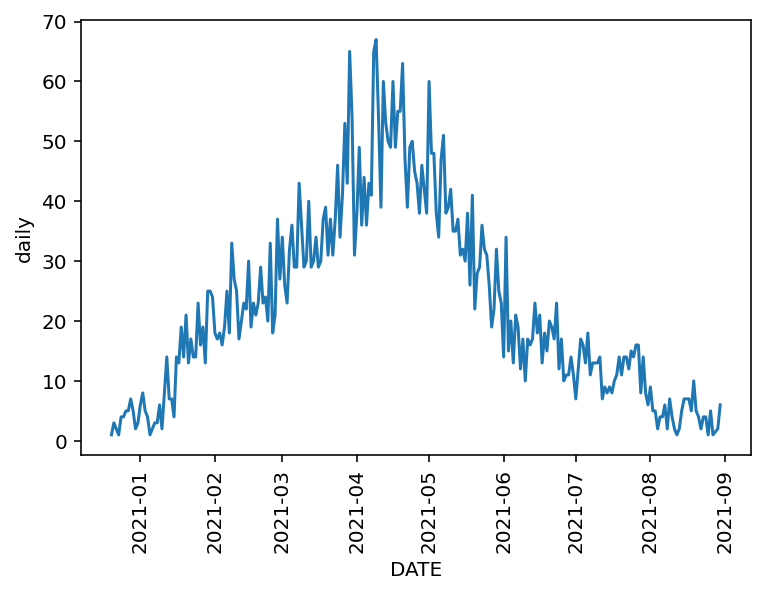

In [60]:
axes = sns.lineplot(x='DATE', y='daily', data=shot_counts)
plt.xticks(rotation=90)
plt.show()

In [61]:
shot_counts.daily.describe()

count    252.000000
mean      22.551587
std       15.778134
min        1.000000
25%       10.000000
50%       19.000000
75%       34.000000
max       67.000000
Name: daily, dtype: float64

In [62]:
patient_immunizations = immunizations.merge(patients, how='left', left_on='PATIENT', right_on='Id')
patient_immunizations['DATE'] = pd.to_datetime(patient_immunizations.DATE)
patient_immunizations['AGE'] = (patient_immunizations.DATE.dt.date - pd.to_datetime(patient_immunizations.BIRTHDATE).dt.date) / np.timedelta64(1, 'Y')
patient_immunizations['AGE_RANGE'] = pd.cut(patient_immunizations.AGE, bins=[0,12,16,18,30,40,50,65,75,120])
cpi = patient_immunizations[patient_immunizations.CODE.isin([207,208,212])]

Looking at the age distribution of those who have received the COVID-19 vaccine

In [63]:
cpi.AGE.describe()

count    5683.000000
mean       49.394735
std        20.364565
min        12.035839
25%        33.491447
50%        50.270711
75%        64.088927
max       110.564899
Name: AGE, dtype: float64

<AxesSubplot:xlabel='AGE', ylabel='Count'>

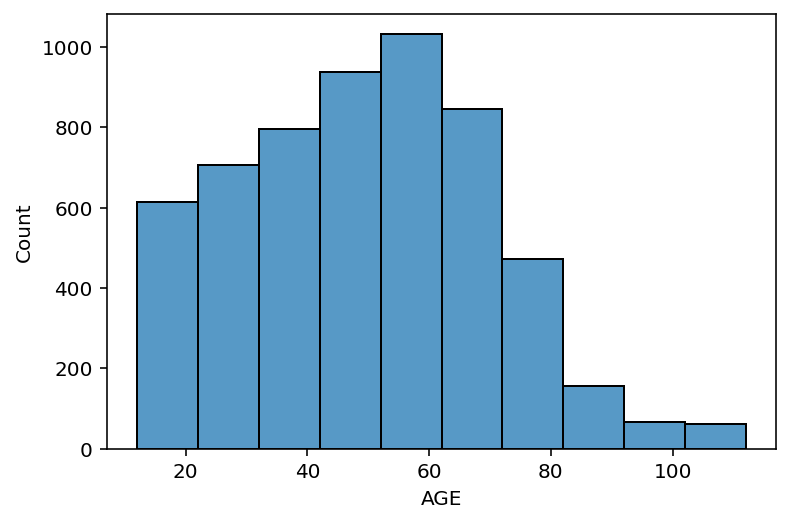

In [64]:
sns.histplot(data=cpi, x="AGE", binwidth=10)

Shots per day by age range

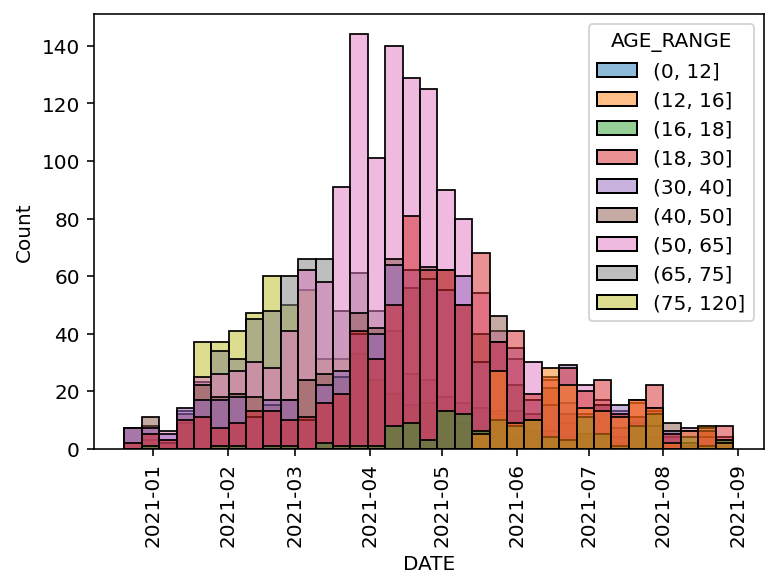

In [65]:
ax = sns.histplot(data=cpi, x="DATE", hue='AGE_RANGE')
ax.tick_params(axis='x', rotation=90)

In [66]:
first_covid_shot = covid_immunizations.groupby(['PATIENT'], as_index=False)['DATE'].first()
possible_break_through = first_covid_shot.merge(conditions[conditions.CODE == 840539006], how='inner', on='PATIENT')

Print a list of breakthrough cases

In [67]:
possible_break_through[possible_break_through.DATE < pd.to_datetime(possible_break_through.START).dt.date]

,PATIENT,DATE,START,STOP,ENCOUNTER,CODE,DESCRIPTION
5,0145fdf9-2f78-b7d8-511b-64ac53dba095,2021-07-25,2021-08-15,NaN,9af523b3-9591-4b8e-9608-143af77d840f,840539006,COVID-19
12,022269b9-39a2-f829-6e6d-f46c091650cc,2021-05-15,2021-05-16,2021-06-11,24349549-c341-3553-5705-e7de985d82c6,840539006,COVID-19
50,37082ca5-5dd6-5bab-4d18-1bc9e0e05d26,2021-04-11,2021-04-24,2021-05-22,ca9331e5-f035-62e3-1266-3502ada2e562,840539006,COVID-19
54,4567af99-93b0-9a91-47cd-7fbf1045ce1a,2021-02-23,2021-02-24,2021-03-19,8fd4e6fd-f061-04ff-a2a2-fdcb41abf1de,840539006,COVID-19
55,5d2ee2df-35a9-b5fd-f402-3d33b78df535,2021-07-05,2021-07-17,2021-08-05,168d1ba1-4bd7-33b5-60dc-03674cce602f,840539006,COVID-19
64,6f3f5d60-223c-a8c8-78a5-c0c5bb227812,2021-04-18,2021-04-30,NaN,e103173e-08ab-ca54-a5a1-ed0ebcaf2798,840539006,COVID-19
65,8f1a29c0-d406-3764-2136-e66df4dea29a,2021-04-18,2021-05-05,2021-06-07,b124c86f-0420-004a-2a31-e36f68eb0bdd,840539006,COVID-19
73,934164d7-bed4-ccca-9245-260af9abb1a6,2021-06-16,2021-06-17,2021-07-16,e3451ac2-d864-b796-c9d4-66b82f3e8950,840539006,COVID-19
111,aedb084f-c635-d90c-4e64-0e37e530ab68,2021-07-11,2021-07-21,2021-08-02,f422b3e9-63ee-5d55-1479-84ab4dc9bf92,840539006,COVID-19
112,b1f7bb78-3165-097d-a403-c2448603293d,2021-04-21,2021-05-06,2021-06-11,7f041fc2-cb42-f982-c948-3581a6c133d6,840539006,COVID-19


In [68]:
patients.shape

(5761, 25)

In [69]:
patients_with_shot_indicator = patients.merge(first_covid_shot, left_on='Id', right_on='PATIENT', how='left', indicator=True)
patients_with_shot_indicator['AGE'] = (datetime.date.today() - pd.to_datetime(patients_with_shot_indicator.BIRTHDATE).dt.date) / np.timedelta64(1, 'Y')
patients_with_shot_indicator['AGE_RANGE'] = pd.cut(patients_with_shot_indicator.AGE, bins=[0,12,16,18,30,40,50,65,75,120])
alive_wsi = patients_with_shot_indicator[patients_with_shot_indicator.DEATHDATE.isna()]
percent_vaxed = alive_wsi.groupby(['AGE_RANGE', '_merge']).size().unstack()
percent_vaxed.both / (percent_vaxed.both + percent_vaxed.left_only)

AGE_RANGE
(0, 12]      0.000000
(12, 16]     0.386555
(16, 18]     0.455782
(18, 30]     0.518779
(30, 40]     0.629969
(40, 50]     0.657321
(50, 65]     0.762548
(65, 75]     0.904429
(75, 120]    0.894737
dtype: float64